In [1]:
import gc
import scanpy as sc
import scarches as sca
import matplotlib.pyplot as plt

/lustre/scratch126/casm/team-cvejic/haoliang/miniconda3/envs/scarches/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/lustre/scratch126/casm/team-cvejic/haoliang/miniconda3/envs/scarches/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
 captum (see https://github.com/pytorch/captum).


In [2]:
PREFIX = "/lustre/scratch126/casm/team-cvejic/"
ADATA_ORI = f"{PREFIX}nelson/data/lung/scRNAseq/outputs/10X_Lung_Healthy_Background_Annotated_v2.h5ad"
CSVPATH = f"{PREFIX}haoliang/pj_NSCLC/results/labeltrans_res/TwoLevelQuery_Healthy_Background_on_Tumour_reference/Questionable_cell_number.csv"
FIGDIR = f"{PREFIX}haoliang/pj_NSCLC/results/labeltrans_res/TwoLevelQuery_Healthy_Background_on_Tumour_reference/"

# Healthy / Background label transfer results

In [3]:
adata_query = sc.read_h5ad(f"{PREFIX}haoliang/pj_NSCLC/results/labeltrans_res/Healthy_Background_immune.h5ad")
trans_res = sc.read_h5ad(f"{PREFIX}haoliang/pj_NSCLC/results/labeltrans_res/TwoLevelQuery_Healthy_Background_on_Tumour_reference/surgery_model_immune/query_latent.h5ad").obs

In [4]:
trans_res.head()

celltype                   batch study  \
0  Anti-inflammatory Mac-H/B  Patient 1 Background 1   H/B   
1  Anti-inflammatory Mac-H/B  Patient 1 Background 1   H/B   
2  Anti-inflammatory Mac-H/B  Patient 1 Background 1   H/B   
3                    DCs-H/B  Patient 1 Background 1   H/B   
4  Anti-inflammatory Mac-H/B  Patient 1 Background 1   H/B   

    pred_celltype-thres0.2  pred_celltype-thres0.35   pred_celltype-thres0.5  
0  Anti-inflammatory Mac-T  Anti-inflammatory Mac-T                     root  
1                    DCs-T                    DCs-T                    DCs-T  
2                    DCs-T                    DCs-T                     root  
3                    DCs-T                    DCs-T                    DCs-T  
4  Anti-inflammatory Mac-T  Anti-inflammatory Mac-T  Anti-inflammatory Mac-T

In [5]:
trans_res.index = adata_query.obs_names

In [6]:
del adata_query
gc.collect()

438

In [7]:
trans_res["pred_celltype-thres0.2"].replace("Rejected", "root & rejected", inplace=True)
trans_res["pred_celltype-thres0.2"].replace("root", "root & rejected", inplace=True)

In [8]:
trans_res["pred_celltype-thres0.2"].unique()

['Anti-inflammatory Mac-T', 'DCs-T', 'root & rejected', 'B cells-T', 'T cells-T', 'CAMLs-T', 'NK cells-T', 'Mast cells-T', 'Pro-inflammatory Mac-T']
Categories (9, object): ['Anti-inflammatory Mac-T', 'B cells-T', 'CAMLs-T', 'DCs-T', ..., 'NK cells-T', 'Pro-inflammatory Mac-T', 'root & rejected', 'T cells-T']

In [9]:
trans_res["celltype"] = trans_res["celltype"].str.replace("-H/B", "")
trans_res["pred_celltype-thres0.2"] = trans_res["pred_celltype-thres0.2"].str.replace("-T", "")

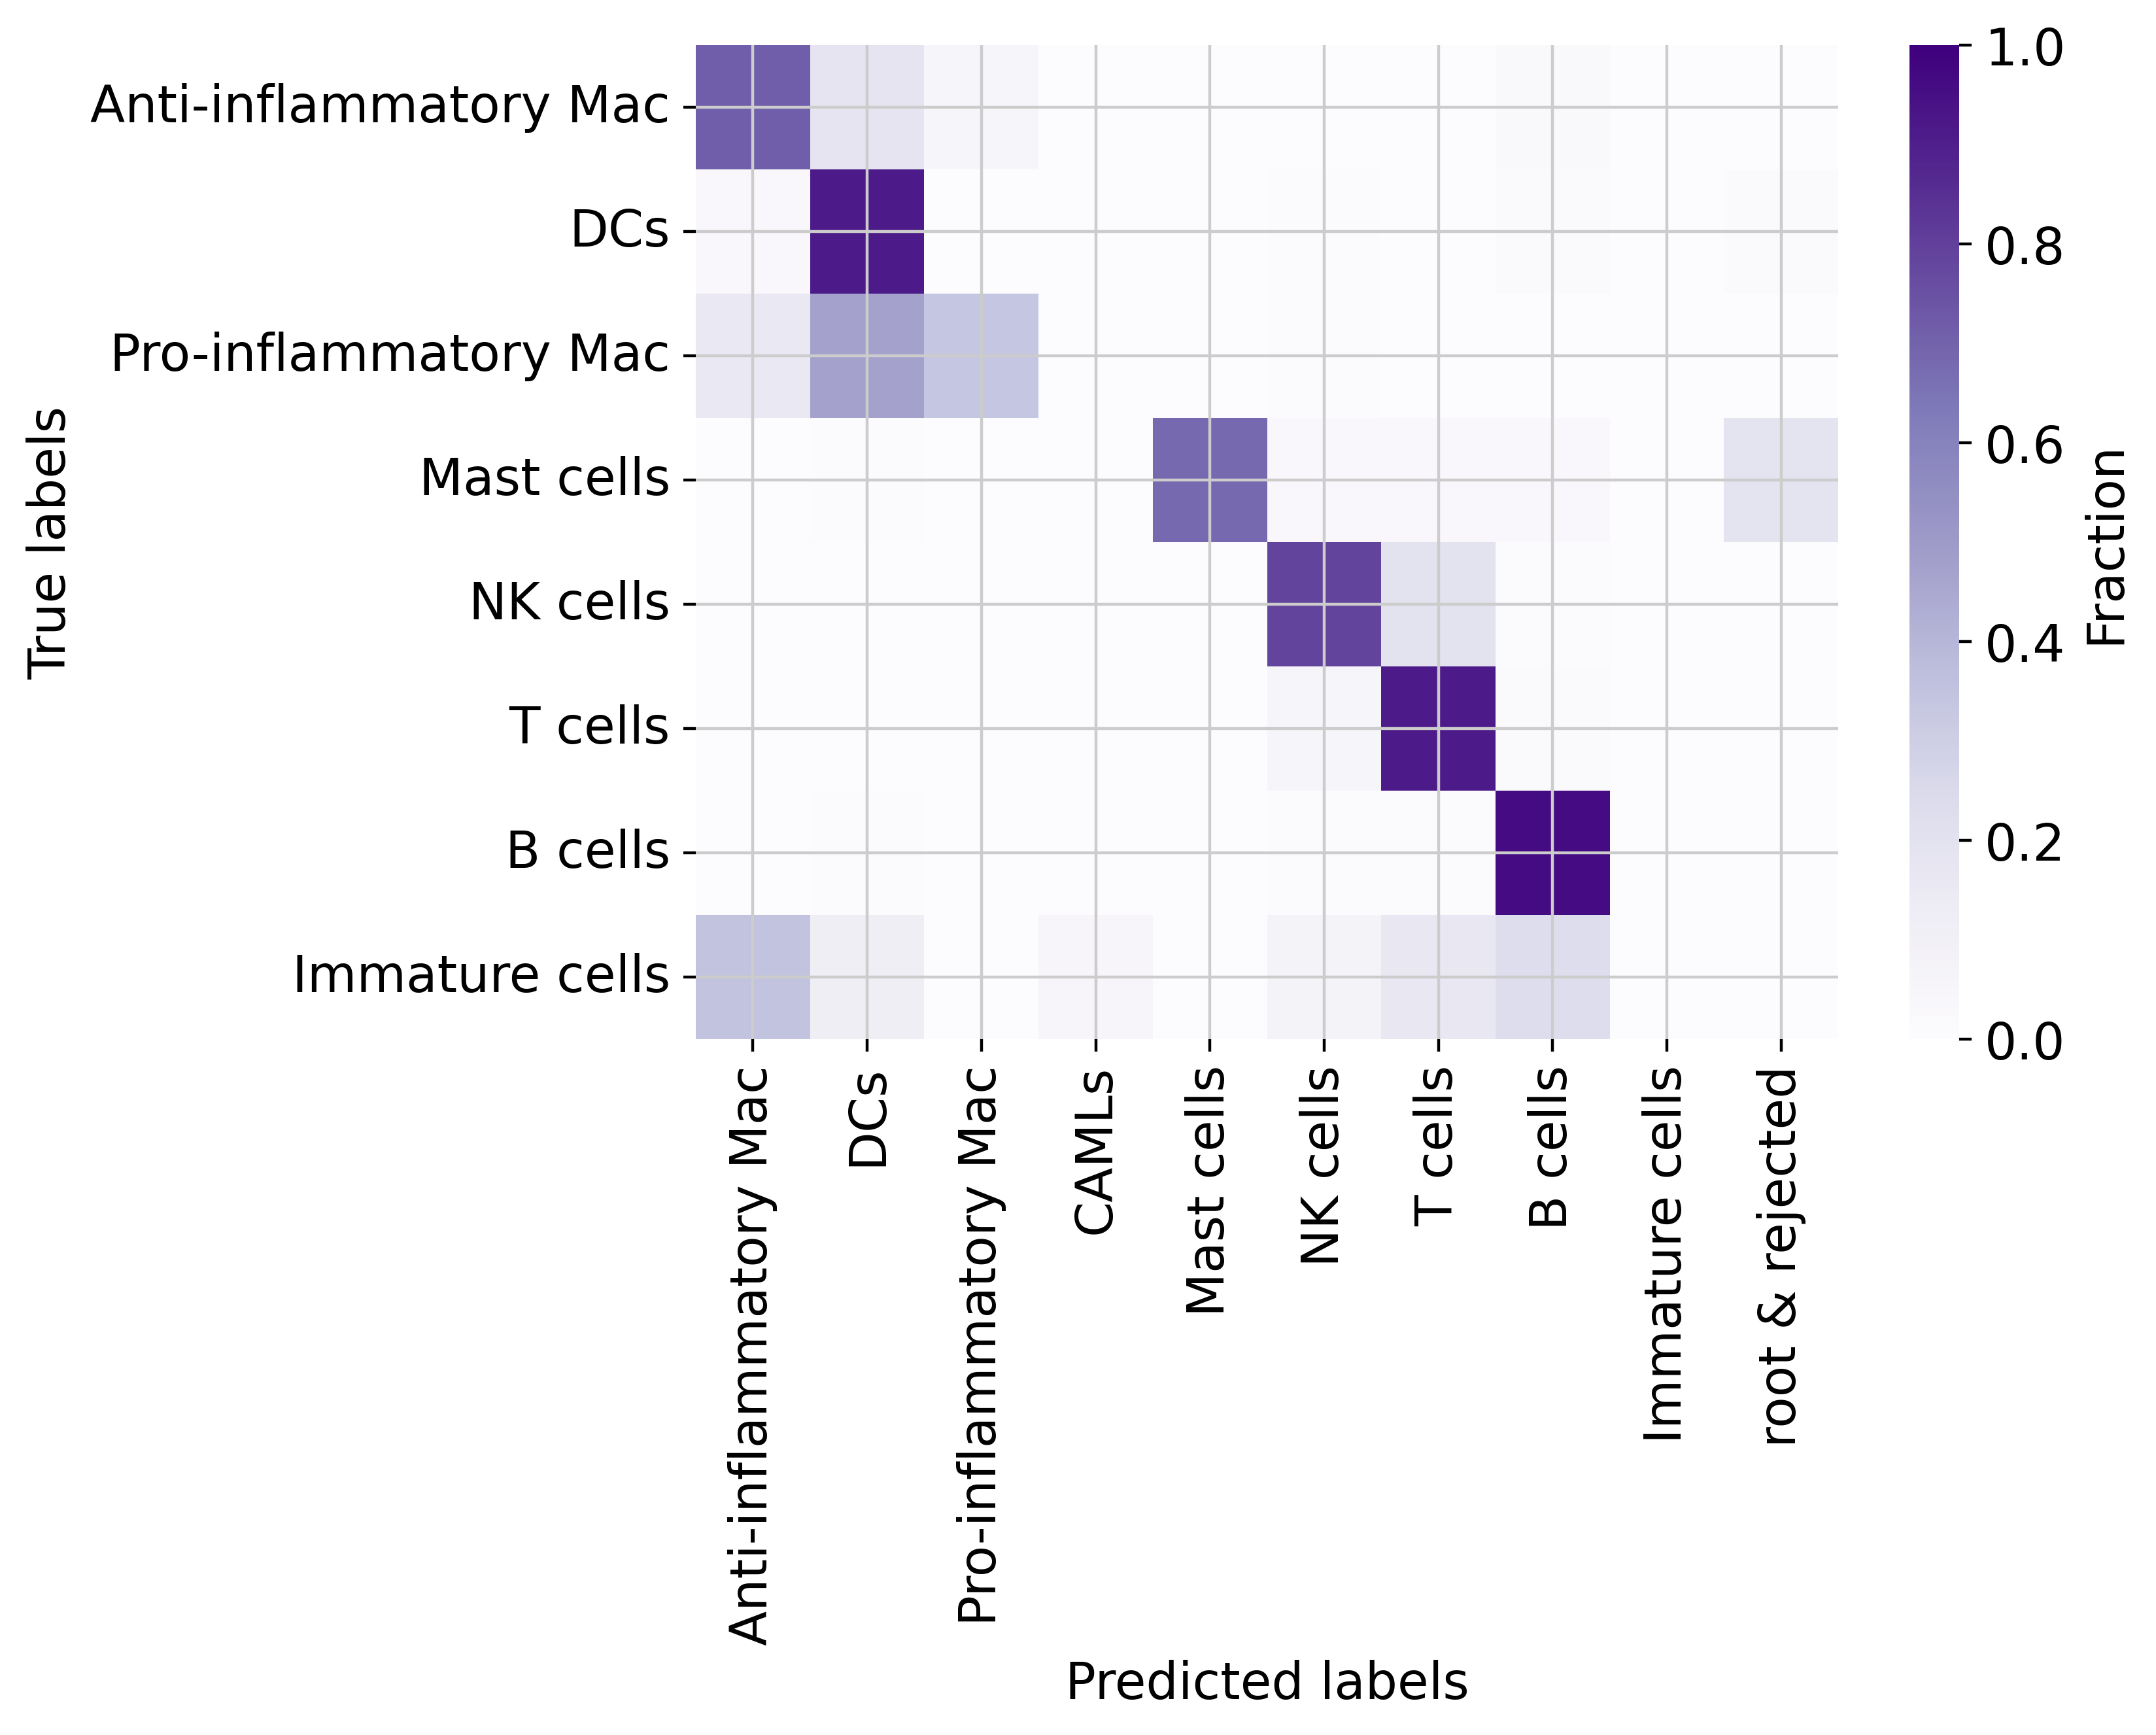

In [10]:
sca.classifiers.scHPL.evaluate.heatmap(true_labels=trans_res["celltype"],
                                       pred_labels=trans_res[f"pred_celltype-thres0.2"],
                                       order_cols=["Anti-inflammatory Mac", "DCs", "Pro-inflammatory Mac", "CAMLs", "Mast cells",
                                                   "NK cells", "T cells", "B cells", "Immature cells", "root & rejected"],
                                       order_rows=["Anti-inflammatory Mac", "DCs", "Pro-inflammatory Mac", "Mast cells",
                                                   "NK cells", "T cells", "B cells", "Immature cells"],
                                       shape=(7, 5), cmap="Purples")
plt.savefig(f"{FIGDIR}Heatmap_new_correspondance.pdf", bbox_inches="tight")

In [11]:
gc.collect()

6274

# Dot plot for questionable cells

In [12]:
GENES2PLT = ["SPI1", "LYZ", "CD14", "FABP4", "MCEMP1", "CD68", "APOE", "C1QB", "C1QC", "CD163", "MARCO", "MRC1",
             "S100A9", "FCN1", "IL1B", "CXCL8", "MNDA", "CD1C", "CLEC4A", "CLEC10A", "JCHAIN", "IRF8", "TCF4"]

In [13]:
adata = sc.read_h5ad(ADATA_ORI)

In [14]:
# Parse latest clustring results and remove previous versions
a = [col[12:] for col in adata.obs.columns if 'Cell types v' in col]
max_num = max([int(x) for x in a if x.isdigit()])
col_name = f"Cell types v{str(max_num)}"
print(f"=====> Using {col_name} as the latest clustering column.")
adata.obs.rename(columns={col_name: "latest_annot"}, inplace=True)
# Only keep relevant columns in observations and variables
adata.obs.drop([col for col in adata.obs.columns if "Cell types" in col],
               axis=1, inplace=True)
adata.obs.drop([col for col in adata.obs.columns if "leiden" in col],
                axis=1, inplace=True)
adata.obs.drop(["batch"], axis=1, inplace=True)
print(adata)

=====> Using Cell types v12 as the latest clustering column.
AnnData object with n_obs × n_vars = 392604 × 25718
    obs: 'n_genes', 'patient', 'sample', 'environment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'sex', 'age', 'sorting', 'smoking history', 'cancer stage', 'tumour type', '# isolated cells', '# estimated cells', 'sangerID', 'cellranger', 'genome', 'patient_sample', 'exp', 'n_counts', 'doublet_scores', 'S_score', 'G2M_score', 'phase', 'PHASE', 'latest_annot'
    var: 'feature_types', 'n_cells', 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    obsm: 'X_pca', 'X_pca_harmonize', 'X_umap'


In [15]:
adata.obs["compare"] = "None"

In [16]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [17]:
gc.collect()

12

# Label questionable cells

In [18]:
def label_compare(adata, sepannot, transannot):
    cells2sel = trans_res.index[(trans_res["celltype"] == sepannot) & (trans_res["pred_celltype-thres0.2"] == transannot)]
    if sepannot == transannot:
        adata.obs.loc[cells2sel, "compare"] = f"Consistent_{sepannot}"
    else:
        adata.obs.loc[cells2sel, "compare"] = f"{sepannot}_as_{transannot}"

## Questionable cell number

In [19]:
label_compare(adata, sepannot="Pro-inflammatory Mac", transannot="Pro-inflammatory Mac")

In [20]:
label_compare(adata, sepannot="DCs", transannot="DCs")

In [21]:
label_compare(adata, sepannot="Pro-inflammatory Mac", transannot="DCs")

In [22]:
adata.obs["compare"] = adata.obs["compare"].astype("category").cat.reorder_categories(["Consistent_Pro-inflammatory Mac",
                                                                                       "Pro-inflammatory Mac_as_DCs",
                                                                                       "Consistent_DCs",
                                                                                       "None"])

/lustre/scratch126/casm/team-cvejic/haoliang/miniconda3/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/tmp/ipykernel_53433/2566808650.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


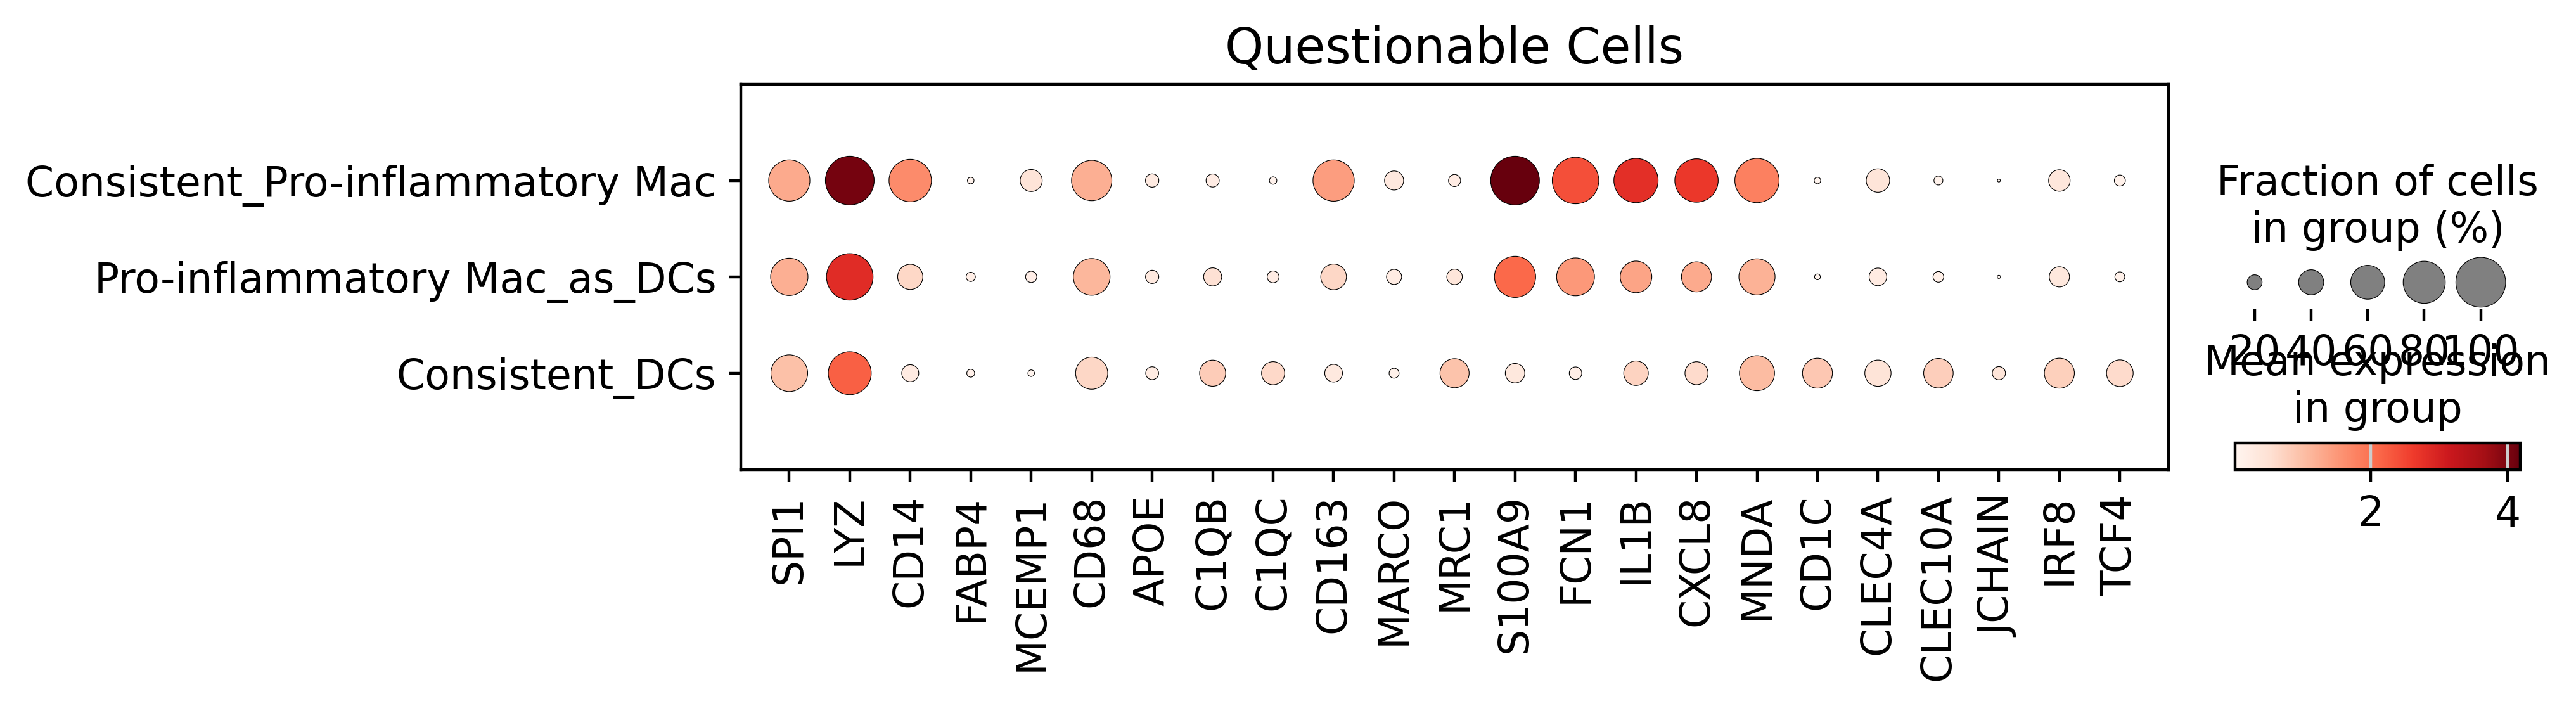

In [23]:
sc.pl.dotplot(adata[adata.obs["compare"] != "None", :], var_names=GENES2PLT, groupby="compare", log=False, figsize=(9, 2),
              dot_max=1, show=False, swap_axes=False, title="Questionable Cells")
plt.tight_layout()
plt.savefig(f"{FIGDIR}Dotplot_questionable_reduced.pdf", bbox_inches="tight")